In [71]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, 
    Conv2DTranspose, 
    Reshape, 
    Input, 
    BatchNormalization, 
    LeakyReLU, 
    Conv2D, 
    Dropout, 
    Flatten
)

In [16]:
model = Sequential([
    Input(10),
    Dense(25),
    Reshape((5,5,1)),
    Conv2DTranspose(1, (3,3), strides = (2,2), padding='same')
])

model.output_shape

(None, 10, 10, 1)

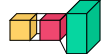

In [17]:
import visualkeras

visualkeras.layered_view(model)

In [18]:
import tensorflow as tf

In [19]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

     |████████████████████████████████| 3.2 MB 4.0 MB/s eta 0:00:01
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9x5waw9s
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-9x5waw9s
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180340 sha256=2b82cf7c7b5d334c96c96f46140310de549003f4806f2856e06910d4e559007a
  Stored in directory: /tmp/pip-ephem-wheel-cache-g5et2f0e/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [20]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [21]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [22]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [23]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [26]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [29]:
def make_generator_model():
    model = Sequential([
        Dense(7*7*256, use_bias = False, input_shape=(100,)),
        BatchNormalization(),
        LeakyReLU(),
        
        Reshape((7,7,256)),
        
        Conv2DTranspose(128, (5,5), strides = (1,1), padding = 'same', use_bias = False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(64, (5,5), strides = (2,2), padding = 'same', use_bias = False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(1, (5,5), strides = (2,2), padding = 'same', use_bias = False, activation = 'tanh')
    ])
    
    return model

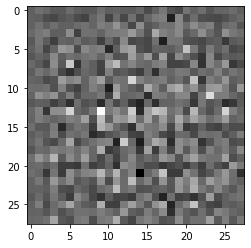

In [30]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [31]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = (28, 28, 1)),
        LeakyReLU(),
        Dropout(0.3),
        
        Conv2D(128, (5,5), strides = (2,2), padding = 'same'),
        LeakyReLU(),
        Dropout(0.3),
        
        Flatten(),
        Dense(1)
    ])
    
    return model

In [36]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00181789]], shape=(1, 1), dtype=float32)


In [37]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [38]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [39]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [40]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [41]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [42]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [43]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [44]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

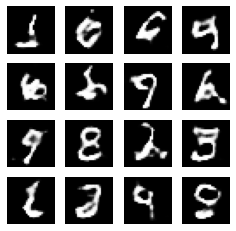

In [45]:
train(train_dataset, EPOCHS)

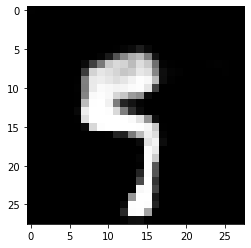

In [63]:
plt.imshow(generator(tf.random.normal([1,100]))[0], cmap = 'gray')

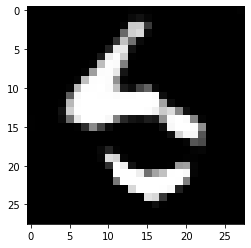

In [64]:
plt.imshow(generator(tf.random.normal([1,100]))[0], cmap = 'gray')

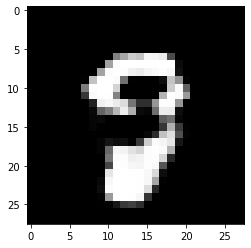

In [65]:
plt.imshow(generator(tf.random.normal([1,100]))[0], cmap = 'gray')

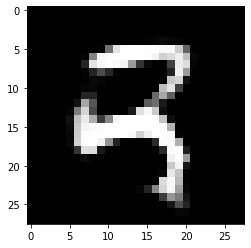

In [66]:
plt.imshow(generator(tf.random.normal([1,100]))[0], cmap = 'gray')

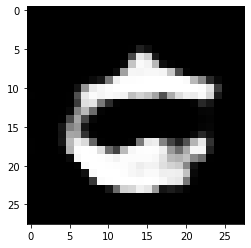

In [67]:
plt.imshow(generator(tf.random.normal([1,100]))[0], cmap = 'gray')

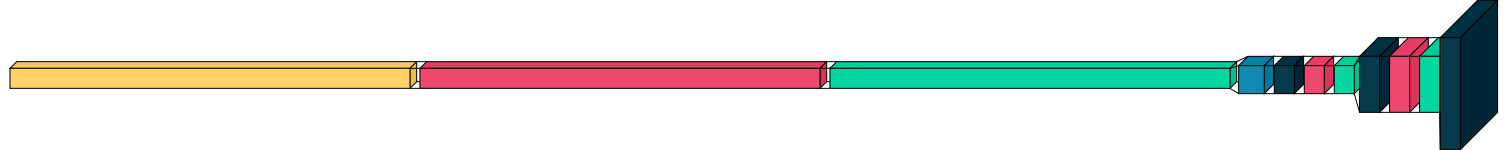

In [72]:
visualkeras.layered_view(generator)

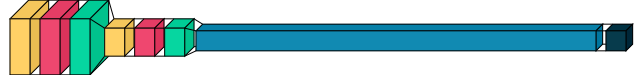

In [73]:
visualkeras.layered_view(discriminator)

In [77]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [78]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-78-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-78-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



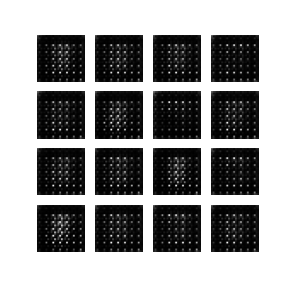

In [79]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)